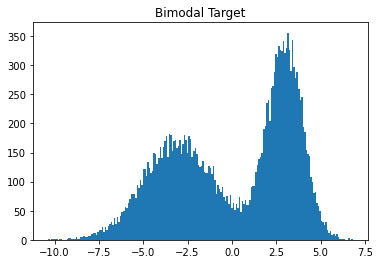

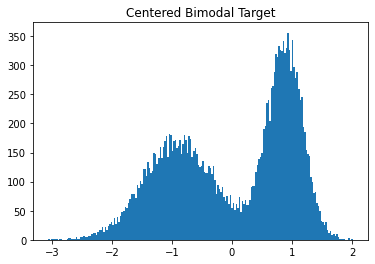

In [1]:
import torch
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import flows.utils as utils
from sklearn.preprocessing import StandardScaler

dist_x1 = dist.Normal(torch.tensor([-3.0]), torch.tensor([2.0]))
dist_x2 = dist.Normal(torch.tensor([3.0]), torch.tensor([1.0]))

X_bimodal = np.concatenate([dist_x1.sample([10000]).numpy(), dist_x2.sample([10000]).numpy()])

plt.hist(X_bimodal, bins=200)
plt.title('Bimodal Target')
plt.show()

X_bimodal = StandardScaler().fit_transform(X_bimodal)

plt.hist(X_bimodal, bins=200)
plt.title('Centered Bimodal Target')
plt.show()

In [2]:
%%time

base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
#base_dist = dist.Uniform(-100, 100.0)
spline_transform_bimodal = T.Spline(1, count_bins=16)
flow_dist_bimodal = dist.TransformedDistribution(base_dist, [spline_transform_bimodal])

steps = 1001
dataset = torch.tensor(X_bimodal, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform_bimodal.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist_bimodal.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist_bimodal.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.4438438415527344
step: 200, loss: 1.2064710855484009
step: 400, loss: 1.1919277906417847
step: 600, loss: 1.1875296831130981
step: 800, loss: 1.1858198642730713
step: 1000, loss: 1.1850188970565796
Wall time: 20.8 s


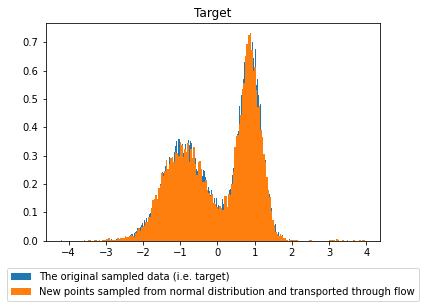

In [3]:
plt.hist(X_bimodal, bins=200, density=True, label='The original sampled data (i.e. target)')
plt.hist(flow_dist_bimodal.sample(torch.Size([20000])).detach().numpy(), bins=200, density=True, label='New points sampled from normal distribution and transported through flow')
plt.title('Target')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

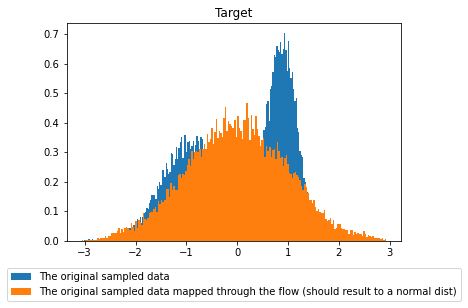

In [4]:
plt.hist(X_bimodal, bins=200, density=True, label='The original sampled data')
plt.hist(spline_transform_bimodal.inv(torch.tensor(X_bimodal)).detach().numpy(), bins=200, density=True, label='The original sampled data mapped through the flow (should result to a normal dist)')
plt.title('Target')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

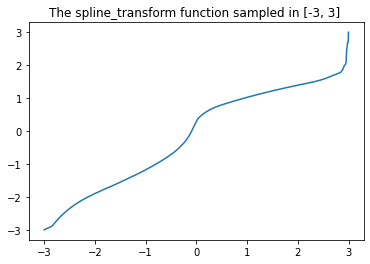

In [5]:
input = np.linspace(-3, 3, 10000)
mapped = spline_transform_bimodal(torch.tensor([[x] for x in input])).detach().numpy()

plt.plot(input, mapped)
plt.title("The spline_transform function sampled in [-3, 3] ")
plt.show()
#print(mapped[5000])

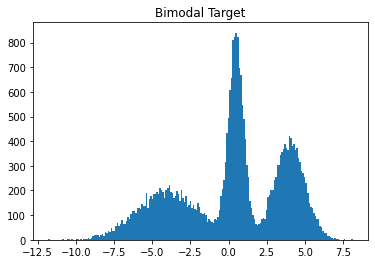

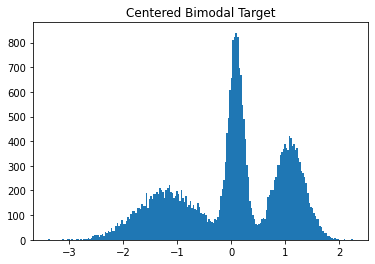

In [6]:
dist_x1 = dist.Normal(torch.tensor([-4.0]), torch.tensor([2.0]))
dist_x2 = dist.Normal(torch.tensor([4.0]), torch.tensor([1.0]))
dist_x3 = dist.Normal(torch.tensor([0.5]), torch.tensor([0.5]))

X_trimodal = np.concatenate([dist_x1.sample([10000]).numpy(), dist_x2.sample([10000]).numpy(), dist_x3.sample([10000]).numpy()])

plt.hist(X_trimodal, bins=200)
plt.title('Bimodal Target')
plt.show()

X_trimodal = StandardScaler().fit_transform(X_trimodal)

plt.hist(X_trimodal, bins=200)
plt.title('Centered Bimodal Target')
plt.show()

In [7]:
%%time

base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
#base_dist = dist.Uniform(-100, 100.0)
spline_transform_trimodal = T.Spline(1, count_bins=20) # TODO: we need more bins for trimodal, to better approximate it
flow_dist_trimodal = dist.TransformedDistribution(base_dist, [spline_transform_trimodal])

steps = 1001
dataset = torch.tensor(X_trimodal, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform_trimodal.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist_trimodal.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist_trimodal.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 4.391690731048584
step: 200, loss: 1.3332266807556152
step: 400, loss: 1.2206007242202759
step: 600, loss: 1.1969553232192993
step: 800, loss: 1.1890039443969727
step: 1000, loss: 1.18378746509552
Wall time: 28 s


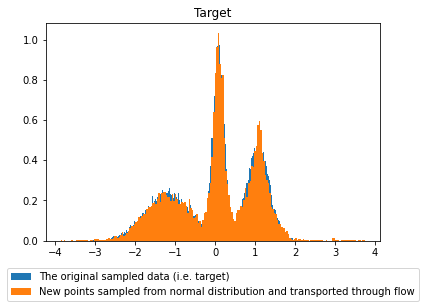

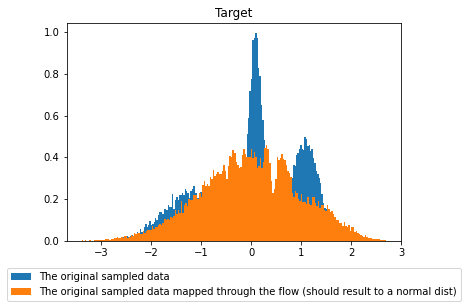

In [8]:
plt.hist(X_trimodal, bins=200, density=True, label='The original sampled data (i.e. target)')
plt.hist(flow_dist_trimodal.sample(torch.Size([20000])).detach().numpy(), bins=200, density=True, label='New points sampled from normal distribution and transported through flow')
plt.title('Target')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

plt.hist(X_trimodal, bins=200, density=True, label='The original sampled data')
plt.hist(spline_transform_trimodal.inv(torch.tensor(X_trimodal)).detach().numpy(), bins=200, density=True, label='The original sampled data mapped through the flow (should result to a normal dist)')
plt.title('Target')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

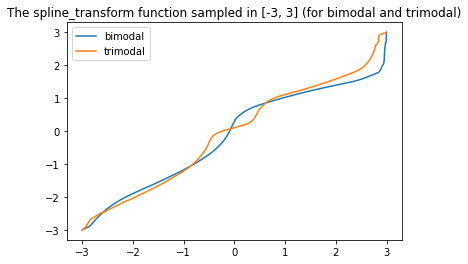

In [9]:
input = np.linspace(-3, 3, 10000)

plt.plot(input, spline_transform_bimodal(torch.tensor([[x] for x in input])).detach().numpy(), label = "bimodal")
plt.plot(input, spline_transform_trimodal(torch.tensor([[x] for x in input])).detach().numpy(), label = "trimodal")
plt.title("The spline_transform function sampled in [-3, 3] (for bimodal and trimodal)")
plt.legend()
plt.show()

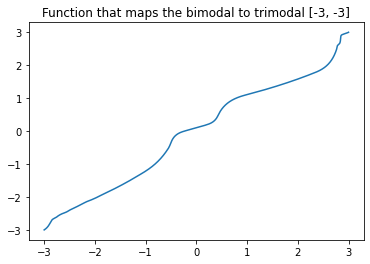

In [10]:
input = np.linspace(-3, 3, 10000)
mapped = spline_transform_bimodal.inv(torch.tensor([[x] for x in input]))
mapped = spline_transform_trimodal(torch.tensor([[x] for x in input]))
plt.plot(input, mapped.detach().numpy())
plt.title("Function that maps the bimodal to trimodal [-3, -3]")
plt.show()

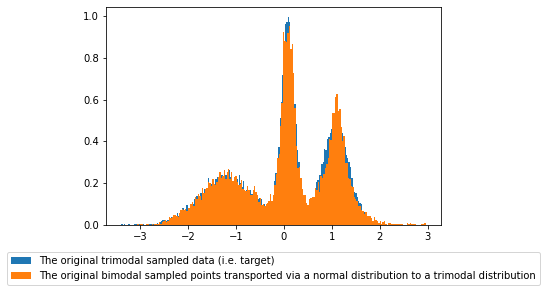

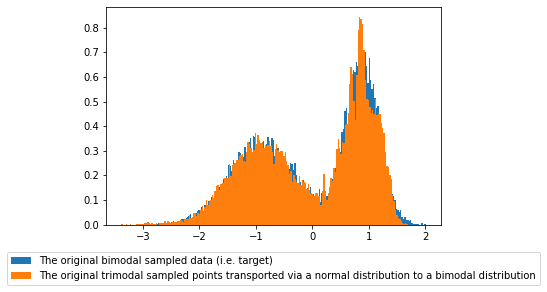

In [11]:
plt.hist(X_trimodal, bins=200, density=True, label='The original trimodal sampled data (i.e. target)')
plt.hist(spline_transform_trimodal(spline_transform_bimodal.inv(torch.tensor(X_bimodal))).detach().numpy(), bins=200, density=True, label="The original bimodal sampled points transported via a normal distribution to a trimodal distribution")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

plt.hist(X_bimodal, bins=200, density=True, label='The original bimodal sampled data (i.e. target)')
plt.hist(spline_transform_bimodal(spline_transform_trimodal.inv(torch.tensor(X_trimodal))).detach().numpy(), bins=200, density=True, label="The original trimodal sampled points transported via a normal distribution to a bimodal distribution")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

In [12]:
# Now with the utils function
bimodal_to_trimodal = utils.samples_to_samples(X_bimodal, X_trimodal)

step: 0, loss: 2.593032121658325
step: 200, loss: 1.2067909240722656
step: 400, loss: 1.19092857837677
step: 600, loss: 1.1869555711746216
step: 800, loss: 1.185305118560791
step: 1000, loss: 1.1844799518585205
step: 0, loss: 6.766338348388672
step: 200, loss: 1.2376071214675903
step: 400, loss: 1.1876214742660522
step: 600, loss: 1.1815459728240967
step: 800, loss: 1.179121732711792
step: 1000, loss: 1.1775689125061035


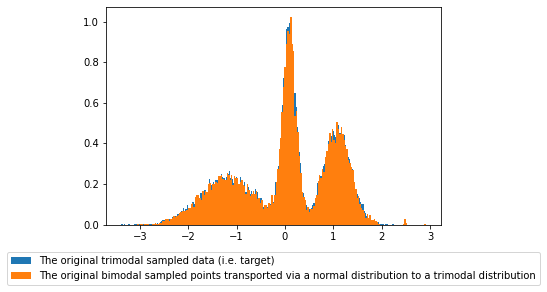

In [13]:
plt.hist(X_trimodal, bins=200, density=True, label='The original trimodal sampled data (i.e. target)')
plt.hist(bimodal_to_trimodal(torch.tensor(X_bimodal)).detach().numpy(), bins=200, density=True, label="The original bimodal sampled points transported via a normal distribution to a trimodal distribution")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()